# Finding Exoplanets through various methods



## Start with loading basic packages

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
#%matplotlib inline

df = pd.read_csv("../exoTrain.csv")
df_const = df.copy()
df.head(6)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16


In [2]:
# there are 5087 observations(rows) and 3198 features(columns)

# Solve the problem using Principle Component Analysis (PCA)

## Standardize the Data

In [3]:
# store Flux 1-3192 in a matrix
x = df.iloc[:, 1:]
features = x.columns.values

In [4]:
# the matrix represents 5087 observations or candidates and 3197 different fluxes over time excluding the label feature
x_train = x.values #in matrix
x_train.shape
#print(x_train.shape)
#print(x_train)

(5087, 3197)

In [5]:
# store Label in a matrix
y_train = df.loc[:,['LABEL']].values
# the matrix represents 5087 observations or candidates and 1 Label column that consists of Label 1 as confirmed non-exoplanet
# and Label 2 as confirmed exoplanet 
#print(y_train.shape)
#print(y_train)


In [6]:
time = np.arange(3197)
print(time)

[   0    1    2 ... 3194 3195 3196]


<IPython.core.display.Javascript object>


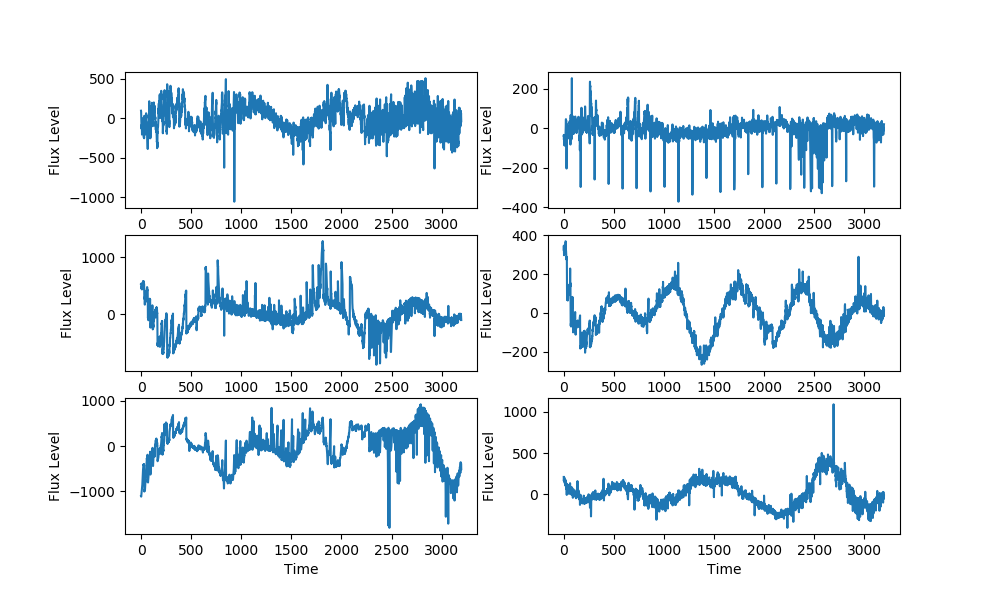

In [7]:
fig = plt.figure(figsize=(10, 6))

for i in range(6):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(time, x_train[i,:])
    ax.set_xlabel('Time')
    ax.set_ylabel('Flux Level')

<IPython.core.display.Javascript object>


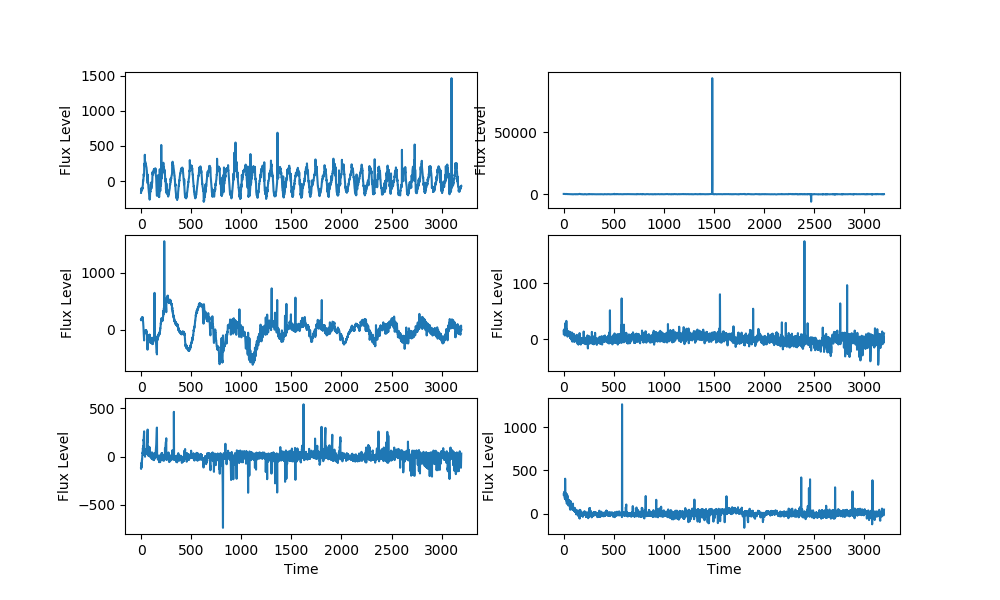

In [8]:
fig = plt.figure(figsize=(10, 6))

for i in range(6):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(time, x_train[i+40,:])
    ax.set_xlabel('Time')
    ax.set_ylabel('Flux Level')

<IPython.core.display.Javascript object>


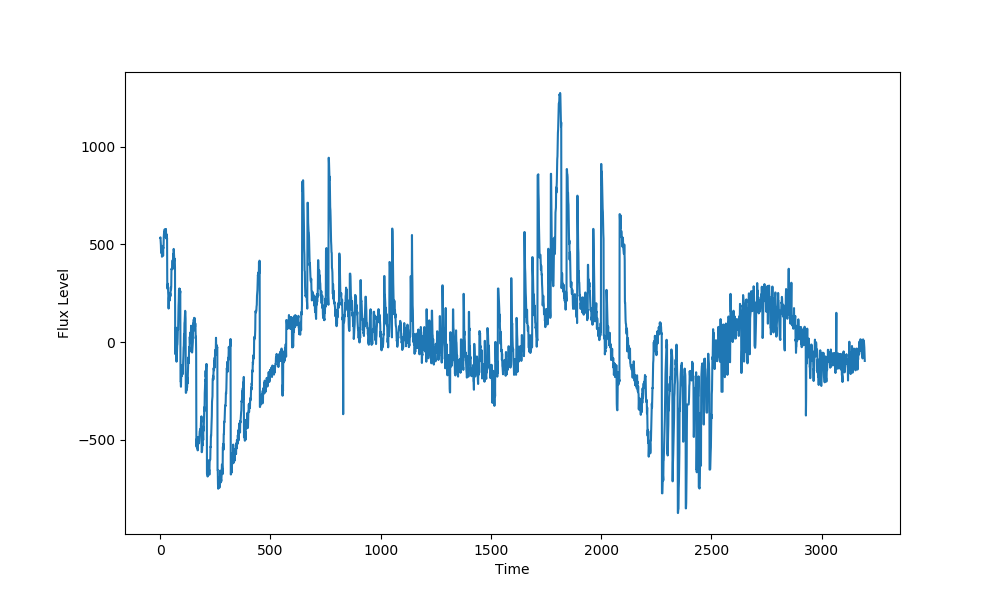

Text(0, 0.5, 'Flux Level')

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(time, x_train[2,:])
plt.xlabel('Time')
plt.ylabel('Flux Level')

<IPython.core.display.Javascript object>


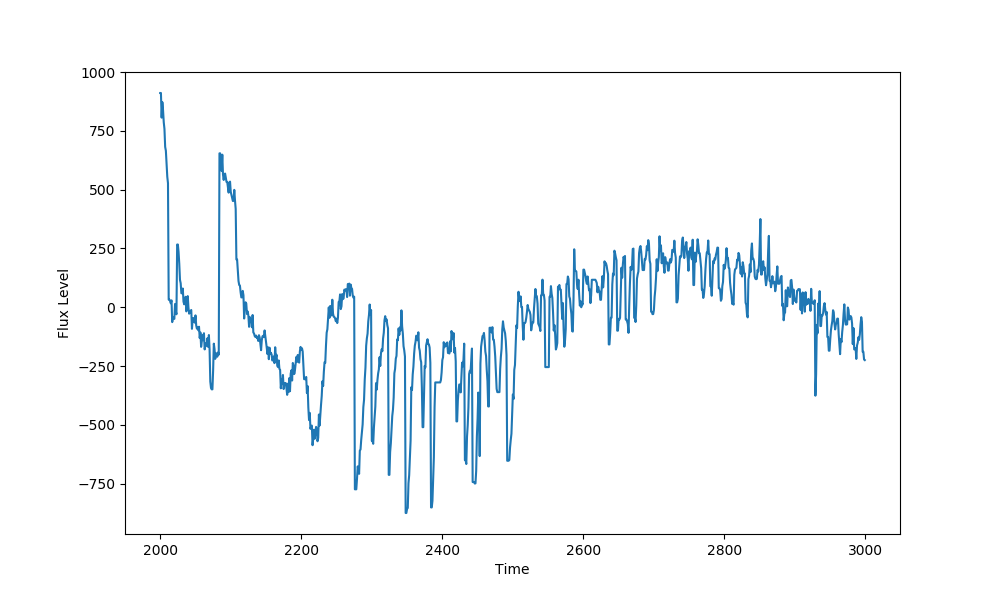

Text(0, 0.5, 'Flux Level')

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(time[2000:3000], x_train[2, 2000:3000])
plt.xlabel('Time')
plt.ylabel('Flux Level')

<IPython.core.display.Javascript object>


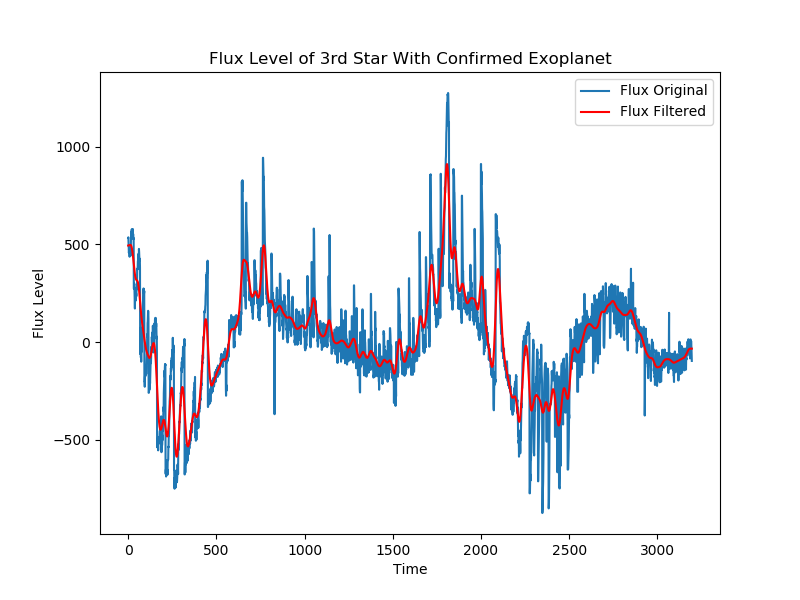

Text(0.5, 1.0, 'Flux Level of 3rd Star With Confirmed Exoplanet')

In [11]:
from scipy import ndimage
from scipy.ndimage import gaussian_filter

flux_original = x_train[2,:]
flux_filtered = ndimage.filters.gaussian_filter(flux_original, sigma=11)

plt.figure(figsize=(8,6))
plt.plot(time, flux_original, label='Flux Original')
plt.plot(time, flux_filtered, '-r', label='Flux Filtered')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Flux Level')
plt.title('Flux Level of 3rd Star With Confirmed Exoplanet')

<IPython.core.display.Javascript object>


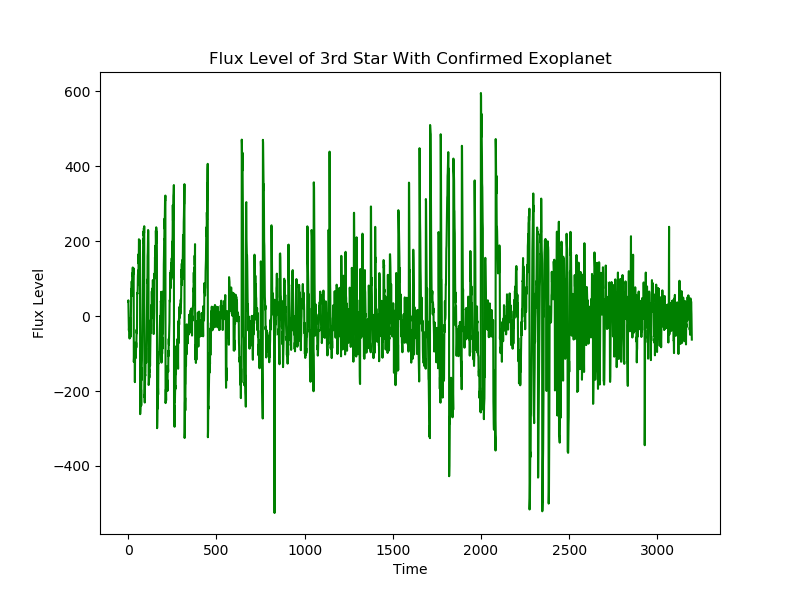

Text(0.5, 1.0, 'Flux Level of 3rd Star With Confirmed Exoplanet')

In [12]:
flux_detrend = flux_original - flux_filtered


plt.figure(figsize=(8,6))
plt.plot(time, flux_detrend, '-g', label='Flux Detrend')
#plt.plot(time, flux_original, label='Flux Original')
#plt.plot(time, flux_filtered, '-r', label='Flux Filtered')
#plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Flux Level')
plt.title('Flux Level of 3rd Star With Confirmed Exoplanet')

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def detrender_normalizer(X):
    flux_original = X
    flux_filtered = ndimage.filters.gaussian_filter(flux_original, sigma=11)
    flux_detrend = flux_original - flux_filtered
    flux_normalized = (flux_detrend-np.mean(flux_detrend)) / (np.max(flux_detrend)-np.min(flux_detrend))
    return flux_normalized

In [14]:
df_train = df.copy()
df_train.iloc[:, 1:] = df_train.iloc[:, 1:].apply(detrender_normalizer,axis=1)
flux_norm = df_train.iloc[:,1:].values
df_train.head()
#print(flux_norm)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,0.108320,0.101905,0.060207,0.029723,0.022260,-0.033026,-0.038745,-0.011656,0.000653,...,-0.044580,-0.061863,-0.063051,0.020120,0.034758,0.063130,0.027358,0.041557,0.004008,-0.025648
1,2,0.037887,0.046987,0.000318,0.033764,-0.040569,-0.030018,-0.057496,-0.057403,-0.057350,...,0.008094,-0.046500,-0.047126,-0.034048,0.002783,0.012836,-0.010725,0.022856,0.040458,0.047694
2,2,0.034564,0.037404,0.017429,0.002178,-0.034259,-0.026106,-0.027853,-0.008738,-0.053623,...,-0.033828,0.041953,0.041913,0.003348,0.011402,0.034581,0.019563,0.004321,-0.032348,-0.056121
3,2,0.019674,0.081463,-0.051379,-0.063438,-0.004877,-0.018902,0.010744,-0.020231,-0.014877,...,0.039275,0.009932,0.008608,0.107240,0.076591,-0.020922,-0.010113,-0.035892,-0.036375,0.056022
4,2,-0.067010,-0.069993,-0.074146,-0.066668,-0.054292,-0.048517,-0.038003,-0.052832,-0.044581,...,-0.034955,0.041262,0.038795,0.054804,0.017460,0.018000,0.032617,0.037813,0.026043,-0.014738


<IPython.core.display.Javascript object>


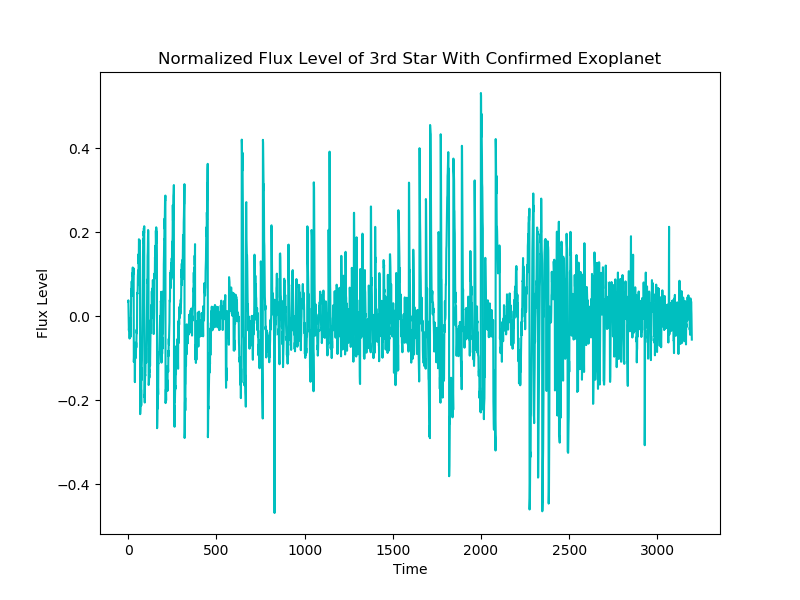

Text(0.5, 1.0, 'Normalized Flux Level of 3rd Star With Confirmed Exoplanet')

In [15]:
plt.figure(figsize=(8,6))
plt.plot(time, flux_norm[2,:], '-c', label='Flux Normalized')
plt.xlabel('Time')
plt.ylabel('Flux Level')
plt.title('Normalized Flux Level of 3rd Star With Confirmed Exoplanet')

In [16]:
def reduce_upper_outliers(df,reduce = 0.01, half_width=4):
    '''
    Since we are looking at dips in the data, we should remove upper outliers.
    The function is taken from here:
    https://www.kaggle.com/muonneutrino/exoplanet-data-visualization-and-exploration
    '''
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values:
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
       # print(sorted_values[:30])
        for j in range(remove):
            idx = sorted_values.index[j]
            #print(idx)
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            #print(idx,idx_num)
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 <1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX.'+str(idx2)] # corrected from 'FLUX-' to 'FLUX.'
                
                count += 1
            new_val /= count # count will always be positive here
            #print(new_val)
            if new_val < values[idx]: # just in case there's a few persistently high adjacent values
                #df.set_value(i,idx,new_val) deprecated use.at[] or .iat[] instead
                df.at[i, idx] = new_val
        
            
    return df

In [17]:
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:])
df_train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,0.108320,0.101905,0.060207,0.029723,0.022260,-0.033026,-0.038745,-0.011656,0.000653,...,-0.044580,-0.061863,-0.063051,0.020120,0.034758,0.063130,0.027358,0.041557,0.004008,-0.025648
1,2,0.037887,0.046987,0.000318,0.033764,-0.040569,-0.030018,-0.057496,-0.057403,-0.057350,...,0.008094,-0.046500,-0.047126,-0.034048,0.002783,0.012836,-0.010725,0.022856,0.040458,0.047694
2,2,0.034564,0.037404,0.017429,0.002178,-0.034259,-0.026106,-0.027853,-0.008738,-0.053623,...,-0.033828,0.041953,0.041913,0.003348,0.011402,0.034581,0.019563,0.004321,-0.032348,-0.056121
3,2,0.019674,0.081463,-0.051379,-0.063438,-0.004877,-0.018902,0.010744,-0.020231,-0.014877,...,0.039275,0.009932,0.008608,0.107240,0.076591,-0.020922,-0.010113,-0.035892,-0.036375,0.056022
4,2,-0.067010,-0.069993,-0.074146,-0.066668,-0.054292,-0.048517,-0.038003,-0.052832,-0.044581,...,-0.034955,0.041262,0.038795,0.054804,0.017460,0.018000,0.032617,0.037813,0.026043,-0.014738


In [18]:
pca = PCA().fit(df_train.iloc[:,1:])

In [19]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

<IPython.core.display.Javascript object>

In [20]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 50)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

<IPython.core.display.Javascript object>

In [21]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(df_train.iloc[:,1:], df_train.iloc[:,0])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
df_test = pd.read_csv("../exoTest.csv")
df_test_const = df_test.copy()
df_test.head(6)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84
5,1,14.28,10.63,14.56,12.42,12.07,12.92,12.27,3.19,8.47,...,3.86,-4.06,-3.56,-1.13,-7.18,-4.78,-4.34,7.67,-0.33,-7.53


In [23]:
df_test.iloc[:, 1:] = df_test.iloc[:, 1:].apply(detrender_normalizer,axis=1)
df_test.iloc[:, 1:] = reduce_upper_outliers(df_test.iloc[:, 1:])
df_test.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,0.115235,0.196665,0.159224,0.055563,0.049487,0.031981,-0.024472,-0.055467,-0.055538,...,-0.065140,-0.054988,-0.071221,-0.118202,-0.079134,0.007880,-0.031257,-0.021840,-0.031088,0.037586
1,2,0.048653,0.046733,0.049623,0.050200,0.051209,0.052671,0.056911,0.057917,0.062347,...,0.021625,-0.006439,-0.022833,-0.048371,-0.063157,-0.079049,-0.092820,-0.099110,-0.092982,-0.073184
2,2,0.423066,0.358798,0.304845,0.262772,0.310815,0.204222,0.153883,0.083775,-0.073256,...,0.050492,-0.026207,-0.019983,-0.031022,-0.054090,-0.157481,-0.065606,-0.141189,0.002991,0.080182
3,2,-0.027100,-0.027760,-0.034009,-0.031721,-0.005205,-0.018420,-0.021936,-0.010089,-0.000827,...,0.070011,0.059529,0.058174,0.049641,0.030706,0.033230,0.032441,-0.010966,-0.052902,-0.040230
4,2,-0.012200,-0.001464,0.001564,0.002803,-0.001655,-0.005274,0.005215,-0.014869,0.003389,...,0.012504,0.001241,0.016600,0.018943,0.012901,-0.010794,-0.009284,-0.000641,-0.004112,0.019181


In [24]:
df_test.shape

(570, 3198)

In [25]:
predicted = logisticRegr.predict(df_test.iloc[:, 1:])
#df_test = df_test.replace(1,'Non-Exoplanet')
#df_test = df_test.replace(2,'Exoplanet')
logisticRegr.score(df_test.iloc[:, 1:] , df_test.iloc[:, 0])
actual = df_test.iloc[:, 0]

In [26]:
target_actual = pd.Series(actual, name='Actual')
target_predicted = pd.Series(predicted, name='Predicted')
df_confusion = pd.crosstab(target_actual, target_predicted)

In [27]:
df_confusion

Predicted,1
Actual,
1,565
2,5


In [28]:
df.LABEL.value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

In [29]:
df_test.LABEL.value_counts()

1    565
2      5
Name: LABEL, dtype: int64

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
smt = SMOTE()
df_const.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [32]:
X_train = df_const.iloc[:,1:]
Y_train = df_const.iloc[:,0]

In [33]:
X_train, Y_train = smt.fit_sample(X_train, Y_train)

In [34]:
print(X_train.shape)
print(X_train)

(10100, 3197)
[[ 93.85        83.81        20.1        ...  61.42         5.08
  -39.54      ]
 [-38.88       -33.83       -58.54       ...   6.46        16.
   19.93      ]
 [532.64       535.92       513.73       ... -28.91       -70.02
  -96.67      ]
 ...
 [112.4756739   93.32949086  61.08732788 ...  16.68638464  19.59445439
    9.28264322]
 [ 12.16044837  20.46289606   9.57495911 ... -11.98907956  -3.06143129
  -11.97682418]
 [115.64129516 108.11428144  81.15644075 ...  62.55188948  33.38483164
   -7.76299363]]


In [35]:
features = list(df_const.iloc[:,1:].columns.values)
df_train = pd.DataFrame(data = X_train, columns = features)
df_train.head(6)

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,139.34,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16


In [36]:
label_train = pd.DataFrame(data = Y_train, columns = ['LABEL'])
label_train.head(6)

,LABEL
0,2
1,2
2,2
3,2
4,2
5,2


In [37]:
df_train = pd.concat([label_train, df_train], axis = 1)
print(df_train.head())
print(df_train.shape)

   LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   

    FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0   -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1   -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2   486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3   311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4 -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      48.57      92.54      39.32      61.42       5.08  

In [38]:
df_train.iloc[:, 1:] = df_train.iloc[:, 1:].apply(detrender_normalizer,axis=1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:])
df_train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,0.108320,0.101905,0.060207,0.029723,0.022260,-0.033026,-0.038745,-0.011656,0.000653,...,-0.044580,-0.061863,-0.063051,0.020120,0.034758,0.063130,0.027358,0.041557,0.004008,-0.025648
1,2,0.037887,0.046987,0.000318,0.033764,-0.040569,-0.030018,-0.057496,-0.057403,-0.057350,...,0.008094,-0.046500,-0.047126,-0.034048,0.002783,0.012836,-0.010725,0.022856,0.040458,0.047694
2,2,0.034564,0.037404,0.017429,0.002178,-0.034259,-0.026106,-0.027853,-0.008738,-0.053623,...,-0.033828,0.041953,0.041913,0.003348,0.011402,0.034581,0.019563,0.004321,-0.032348,-0.056121
3,2,0.019674,0.081463,-0.051379,-0.063438,-0.004877,-0.018902,0.010744,-0.020231,-0.014877,...,0.039275,0.009932,0.008608,0.107240,0.076591,-0.020922,-0.010113,-0.035892,-0.036375,0.056022
4,2,-0.067010,-0.069993,-0.074146,-0.066668,-0.054292,-0.048517,-0.038003,-0.052832,-0.044581,...,-0.034955,0.041262,0.038795,0.054804,0.017460,0.018000,0.032617,0.037813,0.026043,-0.014738


In [39]:
import scipy
def spectrum_getter(X) :
    Spectrum = scipy.fft(X, n=X.size)
    return np.abs(Spectrum)

In [40]:
new_X_train = df_train.iloc[:, 1:]
new_y_train = df_train.iloc[:, 0]
new_X_test = df_test.iloc[:,1:]
new_y_test = df_test.iloc[:, 0]
#new_X_train.head()
#new_X_train = df_train.drop('LABEL', axis=1)
#new_Y_train = df_train.LABEL

#new_Y_train = df_test.drop('LABEL', axis=1)
#new_Y_test = df_test.LABEL
#print(new_X_train.shape)
#print(new_X_test.shape)
#print(new_X_train.head())
print(new_X_train.shape)

(10100, 3197)


In [41]:
df_train.shape
X_train_sp = new_X_train.apply(spectrum_getter, axis=1)
X_test_sp = new_X_test.apply(spectrum_getter, axis=1)
X_train_list = np.array(X_train_sp.values.tolist())
X_test_list = np.array(X_test_sp.values.tolist())
print(X_train_list.shape)
print(X_test_list.shape)

(10100, 3197)
(570, 3197)


In [42]:
label_train = pd.DataFrame(data = Y_train, columns = ['LABEL'])
label_test = pd.DataFrame(data = new_y_test, columns = ['LABEL'])
label_test.shape

(570, 1)

In [43]:
flux_features = []
for k in range(1, 3198):
    s = 'FLUX.' + str(k)
    flux_features.append(s)

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_list)
X_train_norm = scaler.transform(X_train_list)
X_test_norm = scaler.transform(X_test_list)

In [45]:
df_temp_train = pd.DataFrame(data = X_train_norm, columns = flux_features)
df_temp_test = pd.DataFrame(data = X_test_norm, columns = flux_features)
df_temp_train.head(6)

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,-0.285894,-0.127961,-0.219303,-0.049006,-1.264379,0.227115,-0.395755,-0.547689,-0.303350,0.246476,...,0.433037,0.246476,-0.303350,-0.547689,-0.395755,0.227115,-1.264379,-0.049006,-0.219303,-0.127961
1,0.250038,0.035184,0.049850,1.413662,1.598709,1.361455,0.565810,2.428856,0.559405,1.220625,...,1.168125,1.220625,0.559405,2.428856,0.565810,1.361455,1.598709,1.413662,0.049850,0.035184
2,1.251091,1.081457,1.710049,1.743914,-0.172959,-0.384641,-0.516175,0.850475,-0.065722,0.300626,...,1.101096,0.300626,-0.065722,0.850475,-0.516175,-0.384641,-0.172959,1.743914,1.710049,1.081457
3,0.431712,0.504401,-0.547514,0.189666,-0.522358,1.609432,0.500510,0.001651,-0.072162,0.339560,...,0.741974,0.339560,-0.072162,0.001651,0.500510,1.609432,-0.522358,0.189666,-0.547514,0.504401
4,0.074530,0.129021,-0.129585,-0.059461,0.156700,-0.034335,2.172111,-0.148706,-0.747999,-0.937115,...,0.399464,-0.937115,-0.747999,-0.148706,2.172111,-0.034335,0.156700,-0.059461,-0.129585,0.129021
5,-0.568003,-0.003171,-0.271668,-1.021371,-0.639270,-0.494320,-0.820787,-1.057902,-0.826770,-0.831923,...,-0.899966,-0.831923,-0.826770,-1.057902,-0.820787,-0.494320,-0.639270,-1.021371,-0.271668,-0.003171


In [46]:
df_train = pd.concat([label_train, df_temp_train], axis = 1)
df_test = pd.concat([label_test, df_temp_test], axis = 1)
df_train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,-0.285894,-0.127961,-0.219303,-0.049006,-1.264379,0.227115,-0.395755,-0.547689,-0.303350,...,0.433037,0.246476,-0.303350,-0.547689,-0.395755,0.227115,-1.264379,-0.049006,-0.219303,-0.127961
1,2,0.250038,0.035184,0.049850,1.413662,1.598709,1.361455,0.565810,2.428856,0.559405,...,1.168125,1.220625,0.559405,2.428856,0.565810,1.361455,1.598709,1.413662,0.049850,0.035184
2,2,1.251091,1.081457,1.710049,1.743914,-0.172959,-0.384641,-0.516175,0.850475,-0.065722,...,1.101096,0.300626,-0.065722,0.850475,-0.516175,-0.384641,-0.172959,1.743914,1.710049,1.081457
3,2,0.431712,0.504401,-0.547514,0.189666,-0.522358,1.609432,0.500510,0.001651,-0.072162,...,0.741974,0.339560,-0.072162,0.001651,0.500510,1.609432,-0.522358,0.189666,-0.547514,0.504401
4,2,0.074530,0.129021,-0.129585,-0.059461,0.156700,-0.034335,2.172111,-0.148706,-0.747999,...,0.399464,-0.937115,-0.747999,-0.148706,2.172111,-0.034335,0.156700,-0.059461,-0.129585,0.129021


In [47]:
print(df_train.LABEL.value_counts())
print(df_test.LABEL.value_counts())

2    5050
1    5050
Name: LABEL, dtype: int64
1    565
2      5
Name: LABEL, dtype: int64


In [48]:
#from sklearn.preprocessing import normalize
#df_train.iloc[:, 1:] = pd.DataFrame(normalize(df_train.iloc[:, 1:]))
#df_test.iloc[:, 1:] = pd.DataFrame(normalize(df_test.iloc[:, 1:]))
#df_train.head()

In [49]:
X_train = df_train.iloc[:, 1:].values
X_test = df_test.iloc[:, 1:].values

Y_train = df_train.iloc[:, 0].values
Y_test = df_test.iloc[:, 0].values

In [50]:
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=200)
logisticRegr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
predicted = logisticRegr.predict(X_test)
#logisticRegr.score(df_test.iloc[:, 1:] , df_test.iloc[:, 0])
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(predicted, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Predicted,1,2
Actual,,
1,564,1
2,1,4


In [52]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print ('Accuracy:', accuracy_score(Y_test, predicted))
print ('F1 score:', f1_score(Y_test, predicted,pos_label= 2))
print ('Recall:', recall_score(Y_test, predicted,pos_label= 2))
print ('Precision:', precision_score(Y_test, predicted, pos_label= 2))
print ('\n clasification report:\n', classification_report(Y_test, predicted))
print ('\n confussion matrix:\n',confusion_matrix(Y_test, predicted))

Accuracy: 0.9964912280701754
F1 score: 0.8000000000000002
Recall: 0.8
Precision: 0.8

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       0.80      0.80      0.80         5

    accuracy                           1.00       570
   macro avg       0.90      0.90      0.90       570
weighted avg       1.00      1.00      1.00       570


 confussion matrix:
 [[564   1]
 [  1   4]]


In [53]:
%%time
from sklearn.model_selection import cross_val_predict
lrmodel = LogisticRegression(solver = 'lbfgs', max_iter=400)
y_pred = cross_val_predict(lrmodel, X_train, Y_train, cv=10)

Wall time: 1min 18s


In [54]:
%%time
final_lrmodel = lrmodel.fit(X_train, Y_train)
lr_pred = final_lrmodel.predict(X_test)
#np.bincount(y_pred)

Wall time: 6.78 s


In [55]:
print ('Accuracy:', accuracy_score(Y_test, lr_pred))
print ('F1 score:', f1_score(Y_test, lr_pred,pos_label= 2))
print ('Recall:', recall_score(Y_test, lr_pred,pos_label= 2))
print ('Precision:', precision_score(Y_test, lr_pred, pos_label= 2))
print ('\n clasification report:\n', classification_report(Y_test, lr_pred))
print ('\n confussion matrix:\n',confusion_matrix(Y_test, lr_pred))

Accuracy: 0.9964912280701754
F1 score: 0.8000000000000002
Recall: 0.8
Precision: 0.8

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       0.80      0.80      0.80         5

    accuracy                           1.00       570
   macro avg       0.90      0.90      0.90       570
weighted avg       1.00      1.00      1.00       570


 confussion matrix:
 [[564   1]
 [  1   4]]


In [56]:
lr_predict = lrmodel.predict(X_test)

In [57]:
%%time
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', random_state=0, gamma=.01, C=1)
svclassifier.fit(X_train, Y_train)
svm_predicted = svclassifier.predict(X_test)

Wall time: 28 s


In [58]:
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(svm_predicted, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)

In [59]:
confusion_mat

Predicted,1,2
Actual,,
1,563,2
2,1,4


In [60]:
#%%time
#from sklearn.svm import SVC
#svclassifier = SVC(kernel='rbf', random_state=0, gamma=.01, C=1)
#svclassifier.fit(X_train, Y_train)
#svm_predicted = svclassifier.predict(X_test)

In [61]:
#target_actual = pd.Series(Y_test, name='Actual')
#target_predicted = pd.Series(svm_predicted, name='Predicted')
#confusion_mat = pd.crosstab(target_actual, target_predicted)

In [62]:
#confusion_mat

In [88]:
%%time
import xgboost
xgb = xgboost.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
xgb.fit(X_train, Y_train)
xgb_predicted = xgb.predict(X_test)

Wall time: 17min 42s


In [64]:
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(xgb_predicted, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Predicted,1,2
Actual,,
1,563,2
2,1,4


In [65]:
%%time
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)
dtc_predicted = dtc.predict(X_test)

Wall time: 1min 48s


In [66]:
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(dtc_predicted, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Predicted,1,2
Actual,,
1,550,15
2,2,3


In [67]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
rfc_predicted = rfc.predict(X_test)

C:\Users\Nik Hadri Aiman\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [68]:
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(rfc_predicted, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Predicted,1,2
Actual,,
1,564,1
2,3,2


In [70]:
%%time
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
y_pred = gnb.predict(X_test)
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(y_pred, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Wall time: 1.58 s


Predicted,1,2
Actual,,
1,286,279
2,2,3


In [74]:
%%time
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, Y_train)
y_pred_KNN = neigh.predict(X_test)
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(y_pred_KNN, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Wall time: 48.2 s


Predicted,1,2
Actual,,
1,562,3
2,2,3


In [80]:
%%time
from sklearn.ensemble import VotingClassifier

lgr = LogisticRegression(solver = 'lbfgs', max_iter=400)
svc = SVC(kernel='linear', random_state=0, gamma=.01, C=1)
neigh = KNeighborsClassifier()
gnb = GaussianNB()

clf = VotingClassifier(estimators=[
        ('lr', logisticRegr), ('svc', svclassifier), ('knn', neigh), ('nb', gnb)], voting='hard')
clf.fit(X_train, Y_train)
y_pred_clf = clf.predict(X_test)
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(y_pred_clf, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Wall time: 1min 17s


Predicted,1,2
Actual,,
1,564,1
2,2,3


In [81]:
%%time
from sklearn.ensemble import BaggingClassifier
lgr = LogisticRegression(solver = 'lbfgs', max_iter=400)
num_trees = 30
seed = 7
bgc = BaggingClassifier(base_estimator = lgr, 
                          n_estimators = num_trees, 
                          random_state = seed)
bgc.fit(X_train, Y_train)
y_pred_bgc = bgc.predict(X_test)
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(y_pred_bgc, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Wall time: 3min 46s


Predicted,1,2
Actual,,
1,563,2
2,1,4


In [82]:
%%time
from sklearn.ensemble import BaggingClassifier
svc = SVC(kernel='linear', random_state=0, gamma=.01, C=1)
num_trees = 30
seed = 7
bgc = BaggingClassifier(base_estimator = svc, 
                          n_estimators = num_trees, 
                          random_state = seed)
bgc.fit(X_train, Y_train)
y_pred_bgc = bgc.predict(X_test)
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(y_pred_bgc, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Wall time: 7min 35s


Predicted,1,2
Actual,,
1,563,2
2,1,4


In [87]:
%%time
from sklearn.ensemble import BaggingClassifier
cart = DecisionTreeClassifier()
num_trees = 30
seed = 8
bgc = BaggingClassifier(base_estimator = cart, 
                          n_estimators = num_trees, 
                          random_state = seed)
bgc.fit(X_train, Y_train)
y_pred_bgc = bgc.predict(X_test)
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(y_pred_bgc, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Wall time: 25min 23s


Predicted,1,2
Actual,,
1,559,6
2,2,3


In [85]:
%%time
estim = 100
max_feautures = 'auto'
num_trees = 100
seed = 8
rfc = RandomForestClassifier(n_estimators=estim, 
                             bootstrap=True, 
                          max_features='auto')
bgc = BaggingClassifier(base_estimator = rfc, 
                          n_estimators = num_trees, 
                          random_state = seed)
bgc.fit(X_train, Y_train)
y_pred_bgc = bgc.predict(X_test)
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(y_pred_bgc, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Wall time: 1h 2min 34s


Predicted,1,2
Actual,,
1,565,0
2,3,2


In [86]:
%%time
from sklearn.ensemble import AdaBoostClassifier
lgr = LogisticRegression(solver = 'lbfgs', max_iter=400)
ada = AdaBoostClassifier(base_estimator=lgr, n_estimators=100, random_state=0)
ada.fit(X_train, Y_train)
y_pred_ada = ada.predict(X_test)
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(y_pred_ada, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Wall time: 8.51 s


Predicted,1,2
Actual,,
1,563,2
2,1,4


In [89]:
%%time
from sklearn.ensemble import AdaBoostClassifier
xgb = xgboost.XGBClassifier()
ada = AdaBoostClassifier(base_estimator=lgr, n_estimators=100, random_state=0)
ada.fit(X_train, Y_train)
y_pred_ada = ada.predict(X_test)
target_actual = pd.Series(Y_test, name='Actual')
target_predicted = pd.Series(y_pred_ada, name='Predicted')
confusion_mat = pd.crosstab(target_actual, target_predicted)
confusion_mat

Wall time: 9.35 s


Predicted,1,2
Actual,,
1,563,2
2,1,4
